### Introduction:
The following code performs the three cases UCCSD-VQE studied in the paper [Parameter Redundancy in the Unitary Coupled-Cluster Ansatze for Hybrid Variational Quantum Computing](https://arxiv.org/pdf/2301.09825.pdf). The three cases are, 1) Conventional UCCSD-VQE, 2) Spin-adapted UCC-VQE (SA-UCCSD-VQE) and 3) Spin-Adapted Small Amplitude Filtered UCCSD-VQE (SA-SAF-UCCSD-VQE). The description of these methods is elaborated in the above attached paper. Here, we provide the corresponding pyhon code that generates the numerical results included in the paper.

### Prerequisites:
To run the code seemlessly, the following modules of python are required:  
* qiskit
* qiskit_nature
* pyscf
* scipy
* numpy
* pickle
* copy
* matplotlib
* pandas
* time

We begin by importing all the neccessary methods and functions

In [1]:
from scipy.optimize import minimize
from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType, ElectronicStructureMoleculeDriver
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper, BravyiKitaevMapper
from qiskit.opflow.converters import TwoQubitReduction
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
from qiskit_nature.circuit.library.initial_states.hartree_fock import *
from qiskit.opflow import *
from qiskit import Aer
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP
from qiskit.algorithms import VQE
from qiskit_nature.circuit.library.ansatzes import UCC
from qiskit.utils import *
from qiskit_nature.circuit.library.ansatzes.utils import generate_fermionic_excitations
from qiskit.compiler import transpile
import time
import pickle
import copy 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import cycle, islice
from pyscf import gto, scf, fci

### Convention for cluster amplitudes:
In the fillowing, the convension is as follows: \
Letters i,j,.. correspond to occupied $\alpha$ spin orbitals.\
Letters I,J,.. correspond to occupied $\beta$ spin orbitals.\
Letters a,b,.. correspond to unoccupied $\alpha$ spin orbitals.\
Letters A,B,.. correspond to unoccupied $\beta$ spin orbitals.\
So an amplitude of the form t_i_a corresponds to the excitation that takes an electron from occupied $\alpha$ spin orbital 'i', to an unoccupied $\alpha$ spin orbital 'a'. Similar notation convention holds for double excitations.

Let us define a funciton that performs spin adaptation (aka spin adaption) with input as a list of excitations to be included in the cluster operator. The function regroups the set of input excitations in a specific order and stores it in the list `spin_nonadapted_exct`. It then performs spin adaptation on this list, leading to a new list, `spin_adapted_exct`, which only contains unique excitations according to the spin adaptation procedure. 

In [2]:
def perform_spin_adaptation(relevant_excitations):
  global t_i_a, t_I_A, t_ij_ab, t_IJ_AB, t_iJ_aB, t_iJ_Ab, t_iJ_aA, t_Ij_Ab, t_Ij_aB, t_Ij_aA, t_iI_aB, t_iI_Ab, t_iI_aA
  global spin_nonadapted_exct
  global nonadapted_t_i_a_idx, nonadapted_t_I_A_idx, nonadapted_t_ij_ab_idx, nonadapted_t_IJ_AB_idx, nonadapted_t_iJ_aB_idx, nonadapted_t_Ij_Ab_idx, nonadapted_t_iJ_Ab_idx, nonadapted_t_Ij_aB_idx, nonadapted_t_iJ_aA_idx, nonadapted_t_Ij_aA_idx, nonadapted_t_iI_aB_idx, nonadapted_t_iI_Ab_idx, nonadapted_t_iI_aA_idx
  global spin_adapted_exct
  global adapted_t_i_a_idx, adapted_t_ij_ab_idx, adapted_t_iJ_aB_idx, adapted_t_iJ_aA_idx, adapted_t_iI_aB_idx, adapted_t_iI_aA_idx
  global nonadapted_exct_index_extractor
  global adapted_exct_index_extractor
  global adapted_to_nonadapted_idx


  singles = [i for i in relevant_excitations if len(i[0])==1] #extracting the single excitations
  doubles = [i for i in relevant_excitations if len(i[0])==2] #extracting the double excitations


  t_i_a = []
  for i in singles:
      if i[0][0]<nso:
          t_i_a.append(i)

  t_I_A = []
  for i in t_i_a:
      t_I_A.append(((i[0][0]+nso,), (i[1][0]+nso,)))




  t_ij_ab = []
  for i in doubles:
      if i[0][0]<nso and i[0][1]<nso:
          t_ij_ab.append(i)
  t_IJ_AB = []
  for i in t_ij_ab:
      t_IJ_AB.append(((i[0][0]+nso, i[0][1]+nso), (i[1][0]+nso, i[1][1]+nso)))
      
      

  t_iJ_aB = []
  for i in t_ij_ab:
      x = ((i[0][0], i[0][1]+nso), (i[1][0], i[1][1]+nso))
      if x in doubles:
          t_iJ_aB.append(x)
  for i in doubles:
      if i[0][0]<i[0][1]-nso and i[1][0]<i[1][1]-nso and i not in t_iJ_aB:
          t_iJ_aB.append(i)
        
      
  t_iJ_Ab = []
  for i in t_ij_ab:
      x = ((i[0][0], i[0][1]+nso), (i[1][1], i[1][0]+nso))
      if x in doubles:
          t_iJ_Ab.append(x)
  for i in t_iJ_aB:
      x = (i[0], (i[1][1]-nso, i[1][0]+nso))
      if x in doubles and x not in t_iJ_Ab:
          t_iJ_Ab.append(x)

      
      
  t_iJ_aA = []
  for i in doubles:
      if i[0][0]<i[0][1]-nso and i[1][0]==i[1][1]-nso:
          t_iJ_aA.append(i)




  t_Ij_Ab = []
  for i in t_iJ_aB:
      t_Ij_Ab.append( ((i[0][1]-nso, i[0][0]+nso), (i[1][1]-nso, i[1][0]+nso)) )
          
  t_Ij_aB = []
  for i in t_iJ_Ab:
      t_Ij_aB.append(((i[0][1]-nso, i[0][0]+nso), (i[1][1]-nso, i[1][0]+nso)))

  t_Ij_aA = []
  for i in t_iJ_aA:
      t_Ij_aA.append(((i[0][1]-nso, i[0][0]+nso), i[1]))




  t_iI_aB = []
  for i in doubles:
      if i[0][0]==i[0][1]-nso and i[1][0]<i[1][1]-nso:
          t_iI_aB.append(i)

  t_iI_Ab = []
  for i in t_iI_aB:
      t_iI_Ab.append((i[0], (i[1][1]-nso, i[1][0]+nso)))
          
  t_iI_aA = []
  for i in doubles:
      if i[0][0]==i[0][1]-nso and i[1][0]==i[1][1]-nso:
          t_iI_aA.append(i)


  #List of excitations without applying spin adaptation, arranged in a specific order.
  spin_nonadapted_exct = t_i_a + t_I_A + t_ij_ab + t_IJ_AB + t_iJ_aB + t_Ij_Ab + t_iJ_Ab + t_Ij_aB + t_iJ_aA + t_Ij_aA + t_iI_aB + t_iI_Ab + t_iI_aA

  #Given an excitation, the following function returns all the indices of the excitations in the above list that are equivalent to it according to spin adaptation.
  def nonadapted_exct_index_extractor (t_pq_rs):
      return [i for i in range(len(spin_nonadapted_exct)) if spin_nonadapted_exct[i] in t_pq_rs]
  nonadapted_t_i_a_idx = nonadapted_exct_index_extractor(t_i_a)
  nonadapted_t_I_A_idx = nonadapted_exct_index_extractor(t_I_A)
  nonadapted_t_ij_ab_idx = nonadapted_exct_index_extractor(t_ij_ab)
  nonadapted_t_IJ_AB_idx = nonadapted_exct_index_extractor(t_IJ_AB)
  nonadapted_t_iJ_aB_idx = nonadapted_exct_index_extractor(t_iJ_aB)
  nonadapted_t_Ij_Ab_idx = nonadapted_exct_index_extractor(t_Ij_Ab)
  nonadapted_t_iJ_Ab_idx = nonadapted_exct_index_extractor(t_iJ_Ab)
  nonadapted_t_Ij_aB_idx = nonadapted_exct_index_extractor(t_Ij_aB)
  nonadapted_t_iJ_aA_idx = nonadapted_exct_index_extractor(t_iJ_aA)
  nonadapted_t_Ij_aA_idx = nonadapted_exct_index_extractor(t_Ij_aA)
  nonadapted_t_iI_aB_idx = nonadapted_exct_index_extractor(t_iI_aB)
  nonadapted_t_iI_Ab_idx = nonadapted_exct_index_extractor(t_iI_Ab)
  nonadapted_t_iI_aA_idx = nonadapted_exct_index_extractor(t_iI_aA)


  #List of excitations after applying spin adaptation, arranged in a specific order.
  spin_adapted_exct = t_i_a + t_ij_ab + t_iJ_aB + t_iJ_aA + t_iI_aB + t_iI_aA

  #Given an excitation, the following function returns all the indices of the excitations in the above list that are equivalent to it according to spin adaptation.
  def adapted_exct_index_extractor (t_pq_rs):
      return [i for i in range(len(spin_adapted_exct)) if spin_adapted_exct[i] in t_pq_rs]
  adapted_t_i_a_idx = adapted_exct_index_extractor(t_i_a)
  adapted_t_ij_ab_idx = adapted_exct_index_extractor(t_ij_ab)
  adapted_t_iJ_aB_idx = adapted_exct_index_extractor(t_iJ_aB)
  adapted_t_iJ_aA_idx = adapted_exct_index_extractor(t_iJ_aA)
  adapted_t_iI_aB_idx = adapted_exct_index_extractor(t_iI_aB)
  adapted_t_iI_aA_idx = adapted_exct_index_extractor(t_iI_aA)

  #Given an excitation from the list "spin_adapted_exct", the following function returns all the excitations that are equivalent to it and present in the the list "spin_nonadapted_exct".
  def adapted_to_nonadapted_idx (T_pq_rs):
      try:
          idx = adapted_t_i_a_idx.index(T_pq_rs)
          return [nonadapted_t_i_a_idx[idx], nonadapted_t_I_A_idx[idx]]
      except ValueError:
          pass
      
      try:
          idx = adapted_t_ij_ab_idx.index(T_pq_rs)
          return [nonadapted_t_ij_ab_idx[idx], nonadapted_t_IJ_AB_idx[idx]]
      except ValueError:
          pass
      
      try:
          idx = adapted_t_iJ_aB_idx.index(T_pq_rs)
          return [nonadapted_t_iJ_aB_idx[idx], nonadapted_t_Ij_Ab_idx[idx]]
      except ValueError:
          pass
      
      try:
          idx = adapted_t_iJ_aA_idx.index(T_pq_rs)
          return [nonadapted_t_iJ_aA_idx[idx], nonadapted_t_Ij_aA_idx[idx]]
      except ValueError:
          pass

      try:
          idx = adapted_t_iI_aB_idx.index(T_pq_rs)
          return [nonadapted_t_iI_aB_idx[idx], nonadapted_t_iI_Ab_idx[idx]]
      except ValueError:
          pass
      
      try:
          idx = adapted_t_iI_aA_idx.index(T_pq_rs)
          return [nonadapted_t_iI_aA_idx[idx]]
      except ValueError:
          pass

We will now define a function that can evaluate the expectation of a Hamiltonian, given the set of spin-adapted parameters. In the function, the step of evaluating the expectation is done using the function `energy_eval_func`. Note, although at this point we have not defined this function, it will be defined later before calling `adapted_energy_eval_func`.

In [3]:
def adapted_energy_eval_func(adapted_params):
    global nonadapted_params
    nonadapted_params = np.zeros_like(t)
    for i,j in zip([adapted_t_i_a_idx, adapted_t_ij_ab_idx, adapted_t_iJ_aB_idx, adapted_t_iJ_aA_idx, adapted_t_iI_aB_idx, adapted_t_iI_aA_idx], [nonadapted_t_i_a_idx, nonadapted_t_ij_ab_idx, nonadapted_t_iJ_aB_idx, nonadapted_t_iJ_aA_idx, nonadapted_t_iI_aB_idx, nonadapted_t_iI_aA_idx]):
        nonadapted_params[j] = adapted_params[i]
    nonadapted_params[nonadapted_t_I_A_idx] = adapted_params[adapted_t_i_a_idx]
    nonadapted_params[nonadapted_t_IJ_AB_idx] = adapted_params[adapted_t_ij_ab_idx]
    nonadapted_params[nonadapted_t_Ij_Ab_idx] = adapted_params[adapted_t_iJ_aB_idx]
    if len(nonadapted_t_iJ_Ab_idx) == len(nonadapted_t_ij_ab_idx) and len(nonadapted_t_iJ_Ab_idx) == len(nonadapted_t_iJ_aB_idx):
        nonadapted_params[nonadapted_t_iJ_Ab_idx] = adapted_params[adapted_t_ij_ab_idx] + adapted_params[adapted_t_iJ_aB_idx]    
    else:
        for i in nonadapted_t_iJ_Ab_idx:
            p = t_iJ_Ab[i-min(nonadapted_t_iJ_Ab_idx)]
            t1 = ((p[0][0], p[0][1]-nso), (p[1][1]-nso, p[1][0]))
            try:
                idx1 = t_ij_ab.index(t1)
                nonadapted_params[i] += adapted_params[adapted_t_ij_ab_idx[idx1]]
            except ValueError:
                pass
            t2 = ((p[0][0], p[0][1]), (p[1][1]-nso, p[1][0]+nso))
            try:
                idx2 = t_iJ_aB.index(t2)
                nonadapted_params[i] += adapted_params[adapted_t_iJ_aB_idx[idx2]]
            except ValueError:
                pass
    nonadapted_params[nonadapted_t_Ij_aB_idx] = nonadapted_params[nonadapted_t_iJ_Ab_idx]
    nonadapted_params[nonadapted_t_Ij_aA_idx] = adapted_params[adapted_t_iJ_aA_idx]
    nonadapted_params[nonadapted_t_iI_Ab_idx] = adapted_params[adapted_t_iI_aB_idx]

    a = energy_eval_func(nonadapted_params)
    return a

We can now write functions that perform the VQE with either spin-adapted ansatz or with the original ansatz (without spin-adaptation) for `maxiter` number of iterations.

In [4]:
#Given the number of maximum iterations allowed, the following function performs the Spin Adapted VQE.
def spin_adapted_VQE(maxiter):
  global adapted_ordered_params
  global x_0

  nonadapted_params = np.zeros_like(t)       #Will be used later
  print ('Energy at the initial parameter values: ', adapted_energy_eval_func(x_0) + result_exact.nuclear_repulsion_energy)
  
  iter_count = 0                          #Counts the number of iterations taken for convergence.
  #Callback function for minimization


  def print_fun(adapted_params):
      global adapted_ordered_params
      adapted_ordered_params = np.concatenate((adapted_ordered_params, adapted_params.reshape(1,len(spin_adapted_exct))))
      global iter_count
      iter_count += 1
      print ('Iteration %i:' %(iter_count), '   Energy = %f'%(adapted_energy_eval_func(adapted_params) + result_exact.nuclear_repulsion_energy))

#   t0 = time.perf_counter()
  bnds = ((-1,1),)*len(x_0)
  minimization_result = minimize(fun=adapted_energy_eval_func, x0=x_0, method='L-BFGS-B', tol = 1e-8, options={'maxiter': maxiter}, callback = print_fun)
#   t1 = time.perf_counter()

  adapted_ordered_params = np.delete(adapted_ordered_params, (0), axis=0)

  UCC_E = adapted_energy_eval_func(adapted_ordered_params[-1,:]) + result_exact.nuclear_repulsion_energy
  print ('Final energy after minimization: ', UCC_E)  
#   print ('Time ellapsed: ', t1-t0, '\n')

  return adapted_ordered_params










#Given the number of maximum iterations allowed, the following function performs the Non Spin Adapted VQE.
def nonspin_adapted_VQE(maxiter):
  global x_0
  print ('Energy at the initial parameter values: ', energy_eval_func(x_0) + result_exact.nuclear_repulsion_energy)
  UCC_E = 0

  global ordered_params

  iter_count = 0                          #Counts the number of iterations taken for convergence.
  #Callback function for minimization
  def print_fun(x):
      global ordered_params
      ordered_params = np.concatenate((ordered_params, x.reshape(1,len(t))))
      global iter_count
      iter_count += 1
      print ('Iteration %i:' %(iter_count), '   Energy = %f'%(energy_eval_func(x) + result_exact.nuclear_repulsion_energy))

#   t0 = time.perf_counter()
  bnds = ((-1,1),)*len(x_0)
  minimization_result = minimize(fun=energy_eval_func, x0=x_0, method='L-BFGS-B', tol = 1e-8, options={'maxiter': maxiter}, callback = print_fun)
#   t1 = time.perf_counter()

  ordered_params = np.delete(ordered_params, (0), axis=0)

  UCC_E = energy_eval_func(ordered_params[-1,:]) + result_exact.nuclear_repulsion_energy
  print ('Final energy after minimization: ', UCC_E)  
#   print ('Time ellapsed: ', t1-t0, '\n')
  return ordered_params

### Creating a checkpoint:
Before we begin the main part of the code, we have added a small step that acts as a check point i.e. if the code was interrupted in the previous run, the check point ensures that the code resumes from the previous point of interruption.


### Conventions used in storing the data:
We are also saving the data generated by the code in the following format. Create the nest of directories: `Final data/Pre ML Data/LiH` in the directory in which the current code is running. If the code is used to generate data for a different molecule, create the subdirectory after the name of the momlecule in the place of LiH. For example, for LiH molecule, create the nest of directories `Final data/Pre ML Data/LiH`. 

The important sets of data being stored includes energy of the molecule, the time taken to attain convergence and, the parameters of the cluster amplitudes at each step of minimization, for each of the three cases discused above. 

`LiH_SA_0_SAF_0_Energy` corresponds to energy of UCCSD-VQE.\
`LiH_SA_1_SAF_0_Energy` corresponds to energy of SA-UCCSD-VQE.\
`LiH_SA_1_SAF_1_Energy` corresponds to energy of SA-SAF-UCCSD-VQE.

Similar name convention is followed for parameters and time.

In [6]:
#To start from an intermediate step
try:
    with open('Final data/Pre ML Data/LiH/Cases_Completed.pkl', 'rb') as infile:
        Cases_Completed = pickle.load(infile)
except FileNotFoundError:
    Cases_Completed = []

try:
    with open('Final data/Pre ML Data/LiH/Bond_Lengths.pkl', 'rb') as infile:
        Bond_Lengths = pickle.load(infile)
    with open('Final data/Pre ML Data/LiH/LiH_True_Energies.pkl', 'rb') as infile:
        molecule_True_Energies = pickle.load(infile)
    molecule_True_Energies = molecule_True_Energies[:len(Bond_Lengths)]    
except FileNotFoundError:
    Bond_Lengths = []
    molecule_True_Energies = []    
        
        
        

    


try:
    with open('Final data/Pre ML Data/LiH/LiH_SA_0_SAF_0_Params.pkl', 'rb') as infile:
        molecule_SA_0_SAF_0_Params = pickle.load(infile)
    with open('Final data/Pre ML Data/LiH/LiH_SA_0_SAF_0_Energies.pkl', 'rb') as infile:
        molecule_SA_0_SAF_0_Energies = pickle.load(infile)
    with open('Final data/Pre ML Data/LiH/LiH_SA_0_SAF_0_Time.pkl', 'rb') as infile:
        molecule_SA_0_SAF_0_Time = pickle.load(infile) 
    min_len = min([len(molecule_SA_0_SAF_0_Params), len(molecule_SA_0_SAF_0_Energies), len(molecule_SA_0_SAF_0_Time)])
    molecule_SA_0_SAF_0_Params = molecule_SA_0_SAF_0_Params[:min_len]
    molecule_SA_0_SAF_0_Energies = molecule_SA_0_SAF_0_Energies[:min_len]
    molecule_SA_0_SAF_0_Time = molecule_SA_0_SAF_0_Time[:min_len]         
except FileNotFoundError:
    molecule_SA_0_SAF_0_Params = []
    molecule_SA_0_SAF_0_Energies = []
    molecule_SA_0_SAF_0_Time = []


    

try:
    with open('Final data/Pre ML Data/LiH/LiH_SA_1_SAF_0_Params.pkl', 'rb') as infile:
        molecule_SA_1_SAF_0_Params = pickle.load(infile)
    with open('Final data/Pre ML Data/LiH/LiH_SA_1_SAF_0_Energies.pkl', 'rb') as infile:
        molecule_SA_1_SAF_0_Energies = pickle.load(infile)
    with open('Final data/Pre ML Data/LiH/LiH_SA_1_SAF_0_Time.pkl', 'rb') as infile:
        molecule_SA_1_SAF_0_Time = pickle.load(infile)
    min_len = min([len(molecule_SA_1_SAF_0_Params), len(molecule_SA_1_SAF_0_Energies), len(molecule_SA_1_SAF_0_Time)])
    molecule_SA_1_SAF_0_Params = molecule_SA_1_SAF_0_Params[:min_len]
    molecule_SA_1_SAF_0_Energies = molecule_SA_1_SAF_0_Energies[:min_len]
    molecule_SA_1_SAF_0_Time = molecule_SA_1_SAF_0_Time[:min_len]  
except FileNotFoundError:
    molecule_SA_1_SAF_0_Params = []
    molecule_SA_1_SAF_0_Energies = []
    molecule_SA_1_SAF_0_Time = []
    

    
try:
    with open('Final data/Pre ML Data/LiH/LiH_SA_1_SAF_1_Params.pkl', 'rb') as infile:
        molecule_SA_1_SAF_1_Params = pickle.load(infile)
    with open('Final data/Pre ML Data/LiH/LiH_SA_1_SAF_1_Energies.pkl', 'rb') as infile:
        molecule_SA_1_SAF_1_Energies = pickle.load(infile)
    with open('Final data/Pre ML Data/LiH/LiH_SA_1_SAF_1_Time.pkl', 'rb') as infile:
        molecule_SA_1_SAF_1_Time = pickle.load(infile)
    with open('Final data/Pre ML Data/LiH/LiH_spin_adapted_Removable_Idx.pkl', 'rb') as infile:
        molecule_spin_adapted_Removable_Idx = pickle.load(infile)
    with open('Final data/Pre ML Data/LiH/LiH_nonspin_adapted_Removable_Idx.pkl', 'rb') as infile:
        molecule_nonspin_adapted_Removable_Idx = pickle.load(infile)       
    min_len = min([len(molecule_SA_1_SAF_1_Params), len(molecule_SA_1_SAF_1_Energies), len(molecule_SA_1_SAF_1_Time), len(molecule_spin_adapted_Removable_Idx), len(molecule_nonspin_adapted_Removable_Idx)])
    molecule_SA_1_SAF_1_Params = molecule_SA_1_SAF_1_Params[:min_len]
    molecule_SA_1_SAF_1_Energies = molecule_SA_1_SAF_1_Energies[:min_len]
    molecule_SA_1_SAF_1_Time = molecule_SA_1_SAF_1_Time[:min_len]
    molecule_spin_adapted_Removable_Idx = molecule_spin_adapted_Removable_Idx[:min_len]
    molecule_nonspin_adapted_Removable_Idx = molecule_nonspin_adapted_Removable_Idx[:min_len]
except FileNotFoundError:
    molecule_SA_1_SAF_1_Params = []
    molecule_SA_1_SAF_1_Energies = []
    molecule_SA_1_SAF_1_Time = []
    molecule_spin_adapted_Removable_Idx = []
    molecule_nonspin_adapted_Removable_Idx = []     

### Following code block performs the main part of the code: 1) UCCSD-VQE, 2) SA-UCCSD-VQE and, 3) SA-SAF-UCCSD-VQE

In [ ]:
kappa = 2
maxiter = 55      #maxiter is the maximum number of iterations allowed during minimization

#Selecting the backend
backend = Aer.get_backend('qasm_simulator')
backend = Aer.get_backend('aer_simulator_statevector')
optimizer = L_BFGS_B(maxiter)                          

#The code performs three different cases mentioned above: Case 1) SA-SAF-UCCSD-VQE, 2) SA-UCCSD-VQE and 3) UCCSD-VQE
All_cases = [('True', 'True'), ('True', 'False'), ('False', 'False')]
for case_idx in range (len(All_cases)):
    if len(Cases_Completed) == 0:
        case = All_cases[case_idx]
    else:
        case_idx = Cases_Completed[-1]+1
        case = All_cases[case_idx]
        
    print ('_______________________________Starting case: %i_______________________________'%(case_idx+1))
    include_spin_adaptation = case[0]
    include_spin_filtration = case[1]

    #To select a molecule from below, bring it outside of the comment block. "left" and "right" set the range of bond length to be considered.
    '''
    # H4 Linear
    left = 0.5
    right = 1.75
    No_of_points = 15

    #H4 Ring
    radius = 0.5*np.sqrt(2)
    angles = np.linspace(np.pi/12, np.pi/12*5, 30)

    # H6 Linear
    left = 0.5
    right = 3.2
    No_of_points = 30

    # LiH
    left = 0.55
    right = 4.0
    No_of_points = 30

    # H2O
    left = 0.65
    right = 1.425
    No_of_points = 15

    # BeH2
    left = 0.75
    right = 3.75
    No_of_points = 30
    '''

    # LiH
    left = 0.55
    right = 4.0
    No_of_points = 10


    R = np.linspace(left, right, No_of_points)              #The Bond length for the molecule with number of points = "No_of_points"


    #Running the VQE for various bond lengths
    
#     R = []
#     for r_idx in range (len(angles)):                     #Uncomment this if simulating H4 Ring as its parametrization is different from other molecules.
#       theta = angles[r_idx]                               #Uncomment this if simulating H4 Ring
#       r = radius*np.cos(theta)*2                          #Uncomment this if simulating H4 Ring. r is just a measure of molecular srtucture.
#       R.append(r)                                         #Uncomment this if simulating H4 Ring
    for r_idx in range (len(R)):                            
      if len(Bond_Lengths) == 0:                            
          r = R[r_idx]                                      
      else:                                                 
          r_idx = len(Bond_Lengths)                         
          r = R[r_idx]                                      


            
      print ('\n \n _______________________Bond Length = %f    and    iteration number = %i out of %i_______________________' %(r, r_idx+1, len(R)))
      print ('Building molecule... \n')
      
      #Building the molecule
      molecule = Molecule(
          # coordinates are given in Angstrom
          geometry=[
#               BeH2 and LiH:
#               ["Be", [0.0, 0.0, 0.0]],
#               ["H", [0.0, 0.0, -r]],
              ["H", [0.0, 0.0, r]],
              ["Li", [0.0, 0.0, 0.0]],

#               H2O:
#               ["O", [0.0, 0.0, 0.0]],
#               ["H", [np.cos(0.911498202)*r,  np.sin(0.911498202)*r, 0.0]],
#               ["H", [np.cos(0.911498202)*r, -np.sin(0.911498202)*r, 0.0]],
            
#               H4 Ring: 
#               ["H", [0.0, radius*np.cos(theta), radius*np.sin(theta)]],
#               ["H", [0.0, radius*np.cos(theta), -radius*np.sin(theta)]],
#               ["H", [0.0, -radius*np.cos(theta), radius*np.sin(theta)]],
#               ["H", [0.0, -radius*np.cos(theta), -radius*np.sin(theta)]],
            
#               H2, H4 linear and H6 linear:
#               ["H", [0.0, 0.0, 0.0]],
#               ["H", [0.0, 0.0, 0.0+r]],
#               ["H", [0.0, 0.0, 0.0+2*r]],
#               ["H", [0.0, 0.0, 0.0+3*r]],
#               ["H", [0.0, 0.0, 0.0+4*r]],
#               ["H", [0.0, 0.0, 0.0+5*r]]
          ],
          multiplicity=1,  # = 2*spin + 1
          charge=0,
      )
      driver = ElectronicStructureMoleculeDriver(
          molecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PYSCF
      )

      problem = ElectronicStructureProblem(driver)
      second_q_op = problem.second_q_ops()

      qubit_converter = QubitConverter(mapper = JordanWignerMapper(), two_qubit_reduction = True)
      Hamiltonian = qubit_converter.convert(second_q_op[0], num_particles=problem.num_particles)

      nso = int(problem.num_spin_orbitals/2)        #Number of SPATIAL orbitals
      nelec = problem.num_particles                 #Number of alpha and beta electrons in a tuple format

      print ('Building molecule completed! \n')
      print ('No of Spin orbitals: %i' %(nso*2))











      print ('Calculating true ground state energy... \n')

      #Calculating the exact energy
      def exact_diagonalizer(problem, qubit_converter):
          solver = NumPyMinimumEigensolverFactory()
          calc = GroundStateEigensolver(qubit_converter, solver)
          result = calc.solve(problem)
          return result

      result_exact = exact_diagonalizer(problem, qubit_converter)
      exact_energy = np.real(result_exact.eigenenergies[0])
      # print('Exact solution: \n', result_exact)

      molecule_True_Energies.append(result_exact.groundenergy + result_exact.nuclear_repulsion_energy)

      print ('Calculating true ground state energy completed! The ground state energy = %f \n'%(result_exact.groundenergy + result_exact.nuclear_repulsion_energy))

      LiH_True_Energies = copy.copy(molecule_True_Energies)
      if case_idx == 0:
          with open('Final data/Pre ML Data/LiH/LiH_True_Energies.pkl', 'wb') as outfile:
              pickle.dump(LiH_True_Energies, outfile, pickle.HIGHEST_PROTOCOL)



      #Defining the Hartree-Fock state
      HF = HartreeFock(num_spin_orbitals=nso*2, num_particles=nelec, qubit_converter=QubitConverter(mapper=JordanWignerMapper(), two_qubit_reduction=True))


      #Performing the UCC-VQE based on the case chosen above

      iter_count = 0
      temp_UCC_op = UCC(num_spin_orbitals=nso*2, num_particles=nelec, excitations=[1, 2], qubit_converter=QubitConverter(mapper=JordanWignerMapper(), two_qubit_reduction=True), initial_state = HF)
      all_excitations = temp_UCC_op.excitation_list
      t = all_excitations

      # Performing Spin adapted VQE
      if include_spin_adaptation == 'True':
        print ('__________________spin adaptation has been applied__________________ \n')

        perform_spin_adaptation(all_excitations)

        def custom_excitation_list(num_spin_orbitals, num_particles):    #Needed to pass it to the UCC operator generator in the next step
          return spin_nonadapted_exct
        UCC_operator = UCC(num_spin_orbitals=nso*2, num_particles=nelec, excitations=custom_excitation_list, qubit_converter=QubitConverter(mapper=JordanWignerMapper(), two_qubit_reduction=True), initial_state = HF)
        t = UCC_operator.parameters

        # Spin adapted | small amplitude filtered VQE
        if include_spin_filtration == 'True':
          algorithm = VQE(UCC_operator, optimizer=optimizer, quantum_instance=backend)
          energy_eval_func = algorithm.get_energy_evaluation(Hamiltonian, False)
          x_0 = np.zeros(len(spin_adapted_exct))
          adapted_ordered_params = np.zeros((1, len(spin_adapted_exct)))    #Initiating the array that stores the cluster amplitudes at each step of minimization
          
          t0 = time.perf_counter()
          adapted_ordered_params = spin_adapted_VQE(kappa)
          ttmp = time.perf_counter()
          
          removable_idx_1 = []
          j = np.flip(np.argsort(np.abs(adapted_ordered_params[-1, :])))    #Sorting the cluster amplitudes based on their absolute values
          
          #Generating the list of amplitudes that can be removed according to the scheme of small amplitude filtration defined in the paper.
          for i in j:
              if np.abs(adapted_ordered_params[-1,i] - adapted_ordered_params[-2,i]) < 1e-4 and np.abs(adapted_ordered_params[-1,i]) < 1e-5:
                  removable_idx_1.append(i)
          nonadapted_removable_idx = []
          for i in removable_idx_1:
                  nonadapted_removable_idx = nonadapted_removable_idx + adapted_to_nonadapted_idx(i)

          for i in range (len(adapted_t_ij_ab_idx)):
              try:
                  a = removable_idx_1.index(adapted_t_ij_ab_idx[i]) 
                  if adapted_t_iJ_aB_idx[i] in removable_idx_1:
                      nonadapted_removable_idx = nonadapted_removable_idx + [nonadapted_t_iJ_Ab_idx[i], nonadapted_t_Ij_aB_idx[i]]
              except ValueError:
                  pass

          #Storing the removable indices
          molecule_spin_adapted_Removable_Idx.append(removable_idx_1)
          molecule_nonspin_adapted_Removable_Idx.append(nonadapted_removable_idx)

          relevant_excitations = [spin_nonadapted_exct[i] for i in range (len(spin_nonadapted_exct)) if i not in nonadapted_removable_idx]

          perform_spin_adaptation(relevant_excitations)

          def custom_excitation_list(num_spin_orbitals, num_particles):
            return spin_nonadapted_exct
          UCC_operator = UCC(num_spin_orbitals=nso*2, num_particles=nelec, excitations=custom_excitation_list, qubit_converter=QubitConverter(mapper=JordanWignerMapper(), two_qubit_reduction=True), initial_state = HF)
          t = UCC_operator.parameters
          algorithm = VQE(UCC_operator, optimizer=optimizer, quantum_instance=backend)
          energy_eval_func = algorithm.get_energy_evaluation(Hamiltonian, False)

          
          

          print ('__________________small amplitude filtration has been applied__________________ \n')
          
          x_0 = np.array([adapted_ordered_params[-1,i] for i in range (len(adapted_ordered_params[-1,:])) if i not in removable_idx_1])
#           x_0 = np.zeros((len(spin_adapted_exct)))
          adapted_ordered_params = np.zeros((1,len(spin_adapted_exct)))
#           t0 = time.perf_counter()
          print ('Time since first kappa UCCSD-VQE iterations ended: %f'%(ttmp - time.perf_counter()))
          adapted_ordered_params = spin_adapted_VQE(maxiter)
          t1 = time.perf_counter()

          molecule_SA_1_SAF_1_Params.append(adapted_ordered_params)
          molecule_SA_1_SAF_1_Energies.append(adapted_energy_eval_func(adapted_ordered_params[-1, :]) + result_exact.nuclear_repulsion_energy)
          molecule_SA_1_SAF_1_Time.append(t1-t0)

            
          #Storing the results into .pkl files
          LiH_SA_1_SAF_1_Params = copy.copy(molecule_SA_1_SAF_1_Params)
          LiH_SA_1_SAF_1_Energies = copy.copy(molecule_SA_1_SAF_1_Energies)
          LiH_SA_1_SAF_1_Time = copy.copy(molecule_SA_1_SAF_1_Time)
          LiH_spin_adapted_Removable_Idx = copy.copy(molecule_spin_adapted_Removable_Idx)
          LiH_nonspin_adapted_Removable_Idx = copy.copy(molecule_nonspin_adapted_Removable_Idx)  
          
          with open('Final data/Pre ML Data/LiH/LiH_SA_1_SAF_1_Params.pkl', 'wb') as outfile:
                pickle.dump(LiH_SA_1_SAF_1_Params, outfile, pickle.HIGHEST_PROTOCOL)

          with open('Final data/Pre ML Data/LiH/LiH_SA_1_SAF_1_Energies.pkl', 'wb') as outfile:
                pickle.dump(LiH_SA_1_SAF_1_Energies, outfile, pickle.HIGHEST_PROTOCOL)

          with open('Final data/Pre ML Data/LiH/LiH_SA_1_SAF_1_Time.pkl', 'wb') as outfile:
                pickle.dump(LiH_SA_1_SAF_1_Time, outfile, pickle.HIGHEST_PROTOCOL)

          with open('Final data/Pre ML Data/LiH/LiH_spin_adapted_Removable_Idx.pkl', 'wb') as outfile:
                pickle.dump(LiH_spin_adapted_Removable_Idx, outfile, pickle.HIGHEST_PROTOCOL)

          with open('Final data/Pre ML Data/LiH/LiH_nonspin_adapted_Removable_Idx.pkl', 'wb') as outfile:
                pickle.dump(LiH_nonspin_adapted_Removable_Idx, outfile, pickle.HIGHEST_PROTOCOL)
            
            
            
            
            
            
            
            
            
            
            
            
            
        # Performing Spin adapted | non small amplitude filtered VQE
        else:
          print ('\n __________________small amplitude filtration has NOT been applied__________________ \n')
          algorithm = VQE(UCC_operator, optimizer=optimizer, quantum_instance=backend)
          energy_eval_func = algorithm.get_energy_evaluation(Hamiltonian, False)

          adapted_ordered_params = np.zeros((1,len(spin_adapted_exct)))
          x_0 = np.zeros(len(spin_adapted_exct))
          t0 = time.perf_counter()
          adapted_ordered_params = spin_adapted_VQE(maxiter)
          t1 = time.perf_counter()

          molecule_SA_1_SAF_0_Params.append(adapted_ordered_params)
          molecule_SA_1_SAF_0_Energies.append(adapted_energy_eval_func(adapted_ordered_params[-1, :]) + result_exact.nuclear_repulsion_energy)
          molecule_SA_1_SAF_0_Time.append(t1-t0)
        
        
        
          LiH_SA_1_SAF_0_Params = copy.copy(molecule_SA_1_SAF_0_Params)
          LiH_SA_1_SAF_0_Energies = copy.copy(molecule_SA_1_SAF_0_Energies)
          LiH_SA_1_SAF_0_Time = copy.copy(molecule_SA_1_SAF_0_Time)

          with open('Final data/Pre ML Data/LiH/LiH_SA_1_SAF_0_Params.pkl', 'wb') as outfile:
              pickle.dump(LiH_SA_1_SAF_0_Params, outfile, pickle.HIGHEST_PROTOCOL)

          with open('Final data/Pre ML Data/LiH/LiH_SA_1_SAF_0_Energies.pkl', 'wb') as outfile:
              pickle.dump(LiH_SA_1_SAF_0_Energies, outfile, pickle.HIGHEST_PROTOCOL)

          with open('Final data/Pre ML Data/LiH/LiH_SA_1_SAF_0_Time.pkl', 'wb') as outfile:
              pickle.dump(LiH_SA_1_SAF_0_Time, outfile, pickle.HIGHEST_PROTOCOL)
        
        
        
        
        
        
        
        
        
      # Performing nonspin adapted VQE
      else:
        print ('__________________spin adaptation has NOT been applied__________________ \n')

        #Just to have a consistent order of excitations
        perform_spin_adaptation(all_excitations)

        def custom_excitation_list(num_spin_orbitals, num_particles):
          return spin_nonadapted_exct
        UCC_operator = UCC(num_spin_orbitals=nso*2, num_particles=nelec, excitations=custom_excitation_list, qubit_converter=QubitConverter(mapper=JordanWignerMapper(), two_qubit_reduction=True), initial_state = HF)
        t = UCC_operator.parameters

        # Nonspin adapted | small amplitude filtered VQE 
        #Note, this is not a part of the paper and hence this specific case will be skipped while running the code (refer to the list "All_cases" defined above).
        if include_spin_filtration == 'True':

          algorithm = VQE(UCC_operator, optimizer=optimizer, quantum_instance=backend)
          energy_eval_func = algorithm.get_energy_evaluation(Hamiltonian, False)
          
          ordered_params = np.zeros((1,len(t)))
          x_0 = np.zeros(len(t))
          ordered_params = nonspin_adapted_VQE(2)

          removable_idx = []
          j = np.arange(len(ordered_params[-1, :]))
          for i in j:
            if np.abs(ordered_params[1,i] - ordered_params[0,i]) < 1e-4 and np.abs(ordered_params[1,i]) < 1e-5:
              removable_idx.append(i)

          #Storing the removable indices
          molecule_UCCSD_Removable_Idx.append(removable_idx)

          def custom_excitation_list(num_spin_orbitals, num_particles):
            removed_excitations = [all_excitations[i] for i in range (len(all_excitations)) if i not in removable_idx]
            return removed_excitations

          UCC_operator = UCC(num_spin_orbitals=nso*2, num_particles=nelec, excitations=custom_excitation_list, qubit_converter=QubitConverter(mapper=JordanWignerMapper(), two_qubit_reduction=True), initial_state = HF)
          t = UCC_operator.parameters
          x_0 = np.zeros(len(t))
          algorithm = VQE(UCC_operator, optimizer=optimizer, quantum_instance=backend)
          energy_eval_func = algorithm.get_energy_evaluation(Hamiltonian, False)

          print ('\n __________________small amplitude filtration has been applied__________________ \n')
          ordered_params = np.zeros((1,len(t)))
          ordered_params = nonspin_adapted_VQE(maxiter)

        # Performing Nonspin adapted | non small amplitude filtered VQE i.e. the standard UCCSD VQE
        else:
          print ('__________________small amplitude filtration has NOT been applied__________________ \n')

          algorithm = VQE(UCC_operator, optimizer=optimizer, quantum_instance=backend)
          energy_eval_func = algorithm.get_energy_evaluation(Hamiltonian, False)
          ordered_params = np.zeros((1,len(t)))
          x_0 = np.zeros(len(t))

          t0 = time.perf_counter()
          ordered_params = nonspin_adapted_VQE(maxiter)
          t1 = time.perf_counter()

          molecule_SA_0_SAF_0_Params.append(ordered_params)
          molecule_SA_0_SAF_0_Energies.append(energy_eval_func(ordered_params[-1, :]) + result_exact.nuclear_repulsion_energy)
          molecule_SA_0_SAF_0_Time.append(t1-t0)

        
          #Saving the results into .pkl files
          LiH_SA_0_SAF_0_Params = copy.copy(molecule_SA_0_SAF_0_Params)
          LiH_SA_0_SAF_0_Energies = copy.copy(molecule_SA_0_SAF_0_Energies)
          LiH_SA_0_SAF_0_Time = copy.copy(molecule_SA_0_SAF_0_Time)
        
          
          with open('Final data/Pre ML Data/LiH/LiH_SA_0_SAF_0_Params.pkl', 'wb') as outfile:
              pickle.dump(LiH_SA_0_SAF_0_Params, outfile, pickle.HIGHEST_PROTOCOL)

          with open('Final data/Pre ML Data/LiH/LiH_SA_0_SAF_0_Energies.pkl', 'wb') as outfile:
              pickle.dump(LiH_SA_0_SAF_0_Energies, outfile, pickle.HIGHEST_PROTOCOL)

          with open('Final data/Pre ML Data/LiH/LiH_SA_0_SAF_0_Time.pkl', 'wb') as outfile:
              pickle.dump(LiH_SA_0_SAF_0_Time, outfile, pickle.HIGHEST_PROTOCOL)
        
        
        
        
        
      Bond_Lengths.append(r)
      with open('Final data/Pre ML Data/LiH/Bond_Lengths.pkl', 'wb') as outfile:
            pickle.dump(Bond_Lengths, outfile, pickle.HIGHEST_PROTOCOL)
      if len(Bond_Lengths) == len(R):
        break
    Cases_Completed.append(case_idx)
    with open('Final data/Pre ML Data/LiH/Cases_Completed.pkl', 'wb') as outfile:
        pickle.dump(Cases_Completed, outfile, pickle.HIGHEST_PROTOCOL)
        
    Bond_Lengths = []
    with open('Final data/Pre ML Data/LiH/Bond_Lengths.pkl', 'wb') as outfile:
        pickle.dump(Bond_Lengths, outfile, pickle.HIGHEST_PROTOCOL)
    
    print ('_______________________________Case  %i completed_______________________________'%(case_idx+1))
    if len(Cases_Completed) == len(All_cases):
        break
        
        
print ('\n \n \n The code has been executed successfully!')

### Loading the data:
All the data produced in the algorithm are stored in .pkl files. In order to load them back to perform further analysis, run the following code block.

In [8]:
with open('Final data/Pre ML Data/LiH/LiH_True_Energies.pkl', 'rb') as infile:
    LiH_True_Energies = pickle.load(infile)





with open('Final data/Pre ML Data/LiH/LiH_SA_0_SAF_0_Params.pkl', 'rb') as infile:
    LiH_SA_0_SAF_0_Params = pickle.load(infile)

with open('Final data/Pre ML Data/LiH/LiH_SA_0_SAF_0_Energies.pkl', 'rb') as infile:
    LiH_SA_0_SAF_0_Energies = pickle.load(infile)

with open('Final data/Pre ML Data/LiH/LiH_SA_0_SAF_0_Time.pkl', 'rb') as infile:
    LiH_SA_0_SAF_0_Time = pickle.load(infile)





with open('Final data/Pre ML Data/LiH/LiH_SA_1_SAF_0_Params.pkl', 'rb') as infile:
    LiH_SA_1_SAF_0_Params = pickle.load(infile)

with open('Final data/Pre ML Data/LiH/LiH_SA_1_SAF_0_Energies.pkl', 'rb') as infile:
    LiH_SA_1_SAF_0_Energies = pickle.load(infile)

with open('Final data/Pre ML Data/LiH/LiH_SA_1_SAF_0_Time.pkl', 'rb') as infile:
    LiH_SA_1_SAF_0_Time = pickle.load(infile)

    



with open('Final data/Pre ML Data/LiH/LiH_SA_1_SAF_1_Params.pkl', 'rb') as infile:
    LiH_SA_1_SAF_1_Params = pickle.load(infile)

with open('Final data/Pre ML Data/LiH/LiH_SA_1_SAF_1_Energies.pkl', 'rb') as infile:
    LiH_SA_1_SAF_1_Energies = pickle.load(infile)

with open('Final data/Pre ML Data/LiH/LiH_SA_1_SAF_1_Time.pkl', 'rb') as infile:
    LiH_SA_1_SAF_1_Time = pickle.load(infile)

with open('Final data/Pre ML Data/LiH/LiH_spin_adapted_Removable_Idx.pkl', 'rb') as infile:
    LiH_spin_adapted_Removable_Idx = pickle.load(infile)

with open('Final data/Pre ML Data/LiH/LiH_nonspin_adapted_Removable_Idx.pkl', 'rb') as infile:
    LiH_nonspin_adapted_Removable_Idx = pickle.load(infile)

## Results:

### Average of Filtered Amplitudes

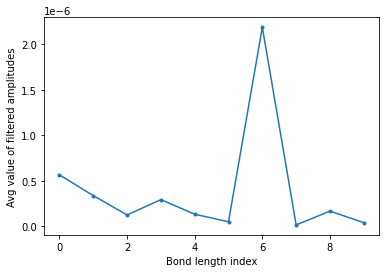

In [9]:
# LiH
kappa = 2
LiH_avg_removable_param = []
for i in range (len(LiH_SA_0_SAF_0_Params)):
    ordered_params = LiH_SA_0_SAF_0_Params[i]
    temp_idx = []
    for j in range (len(ordered_params[-1,:])):
        if np.abs(ordered_params[kappa-1,j] - ordered_params[kappa-2,j]) < 1e-4 and np.abs(ordered_params[kappa-1,j]) < 1e-5:
          temp_idx.append(j)
    b = ordered_params[-1,temp_idx]
    LiH_avg_removable_param.append(np.abs(np.mean(b)))
    
plt.plot(LiH_avg_removable_param, '.-', label = 'H$_4$ Linear')
plt.xlabel('Bond length index')
plt.ylabel('Avg value of filtered amplitudes')
plt.show()

### Potential Energy Surface

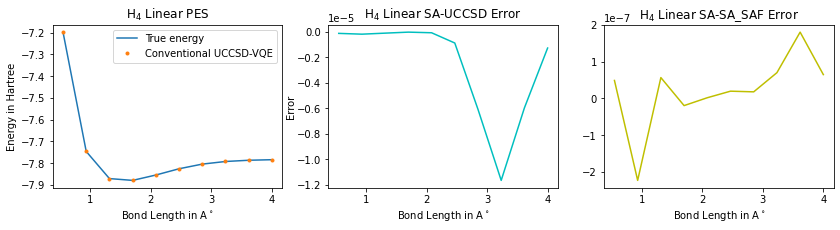

In [10]:
# LiH
left = 0.55
right = 4.0
No_of_points = 10
R = np.linspace(left, right, No_of_points)


plt.figure(figsize=(14, 3)) 
plt.subplot(1,3,1)
plt.plot(R, LiH_True_Energies, label='True energy')
plt.plot(R, LiH_SA_0_SAF_0_Energies, '.', label='Conventional UCCSD-VQE')

plt.legend()
plt.title('H$_4$ Linear PES')
plt.xlabel('Bond Length in A$^\circ$')
plt.ylabel('Energy in Hartree')

plt.subplot(1,3,2)
plt.ticklabel_format(style='sci', axis='y', scilimits=(-3,10))
plt.plot(R, np.array(LiH_SA_0_SAF_0_Energies)-np.array(LiH_SA_1_SAF_0_Energies), color='c')
plt.title('H$_4$ Linear SA-UCCSD Error')
plt.xlabel('Bond Length in A$^\circ$')
plt.ylabel('Error', labelpad=1)

plt.subplot(1,3,3)
plt.plot(R, np.array(LiH_SA_1_SAF_0_Energies)-np.array(LiH_SA_1_SAF_1_Energies), color='y')
plt.title('H$_4$ Linear SA-SA_SAF Error ')
plt.xlabel('Bond Length in A$^\circ$')
plt.show()

### Number of Amplitudes

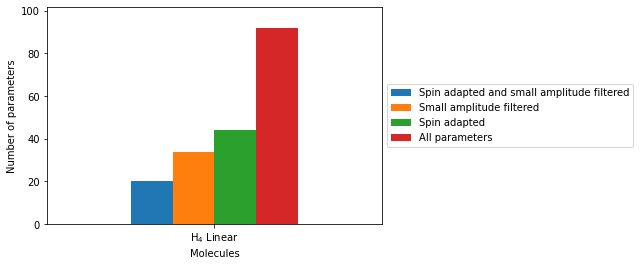

In [11]:
LiH_no_SA_0_SAF_0_Params = len(LiH_SA_0_SAF_0_Params[0][-1,:])
LiH_no_SA_1_SAF_0_Params = len(LiH_SA_1_SAF_0_Params[0][-1,:])
LiH_no_SA_1_SAF_1_Params = len(LiH_SA_1_SAF_1_Params[0][-1,:])
LiH_11 = LiH_no_SA_1_SAF_1_Params
LiH_10 = LiH_no_SA_1_SAF_0_Params
LiH_00 = LiH_no_SA_0_SAF_0_Params
LiH_01 = len(LiH_SA_0_SAF_0_Params[5][-1,:])-len(LiH_nonspin_adapted_Removable_Idx[5])


All_11 = [LiH_11]
All_10 = [LiH_10]
All_00 = [LiH_00]
All_01 = [LiH_01]


Molecules = ['H$_4$ Linear']
df = pd.DataFrame({'Spin adapted and small amplitude filtered': All_11, 'Small amplitude filtered': All_01, 'Spin adapted': All_10,
                   'All parameters': All_00}, index=Molecules)

ax = df.plot.bar(stacked=False, ylim=(0,max(All_00)+10), rot=0)
ax.set_xlabel("Molecules")
ax.set_ylabel("Number of parameters")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Time Taken for Convergence

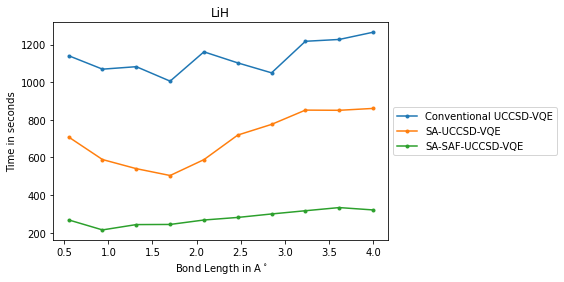

In [12]:
# LiH
left = 0.55
right = 4.0
No_of_points = 10
R = np.linspace(left, right, No_of_points)

plt.figure(figsize=(6,4))

plt.title('LiH')

plt.plot(R, LiH_SA_0_SAF_0_Time, '.-', label='Conventional UCCSD-VQE')
plt.plot(R, LiH_SA_1_SAF_0_Time, '.-', label='SA-UCCSD-VQE')
plt.plot(R, LiH_SA_1_SAF_1_Time, '.-', label='SA-SAF-UCCSD-VQE')

plt.xlabel('Bond Length in A$^\circ$')
plt.ylabel('Time in seconds')


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.savefig('LiH_Different_Kappa_Time.pdf', bbox_inches='tight')
plt.show()

### Circuit depth and number of CNOTs

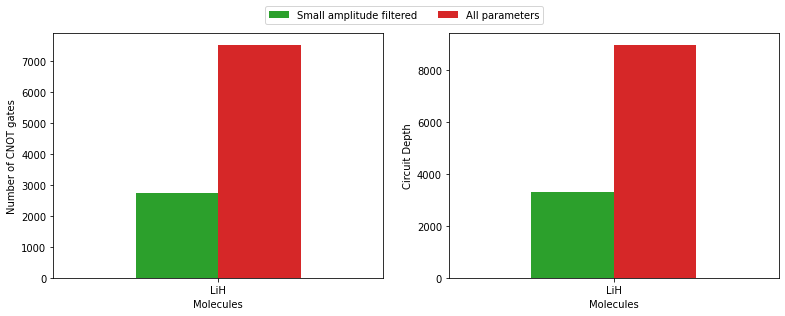

In [13]:
# mol_H4_Linear = {'name': 'H$_4$_Linear', 'nso': 4, 'nelec': 4, 'depth_00': 0, 'cx_00': 0, 'depth_10': 0, 'cx_10': 0, 'depth_11': 0, 'depth_10': 0, 'cx_11': 0, 'cx_10': 0, 'spin_adapted_removable_idx': H4_Linear_spin_adapted_Removable_Idx[5], 'nonspin_adapted_removable_idx': H4_Linear_nonspin_adapted_Removable_Idx[5]}
# mol_H4_Ring = {'name': 'H$_4$_Ring', 'nso': 4, 'nelec': 4, 'depth_00': 0, 'cx_00': 0, 'depth_10': 0, 'cx_10': 0, 'depth_11': 0, 'depth_10': 0, 'cx_11': 0, 'cx_10': 0, 'spin_adapted_removable_idx': H4_Ring_spin_adapted_Removable_Idx[5], 'nonspin_adapted_removable_idx': H4_Ring_nonspin_adapted_Removable_Idx[5]}
mol_LiH = {'name': 'LiH', 'nso': 6, 'nelec': 4, 'depth_00': 0, 'cx_00': 0, 'depth_10': 0, 'cx_10': 0, 'depth_11': 0, 'depth_10': 0, 'cx_11': 0, 'cx_10': 0, 'spin_adapted_removable_idx': LiH_spin_adapted_Removable_Idx[5], 'nonspin_adapted_removable_idx': LiH_nonspin_adapted_Removable_Idx[5]}
# mol_H6 = {'name': 'H$_6$', 'nso': 6, 'nelec': 6, 'depth_00': 0, 'cx_00': 0, 'depth_10': 0, 'cx_10': 0, 'depth_11': 0, 'depth_10': 0, 'cx_11': 0, 'cx_10': 0, 'spin_adapted_removable_idx': H6_spin_adapted_Removable_Idx[5], 'nonspin_adapted_removable_idx': H6_nonspin_adapted_Removable_Idx[5]}
# mol_H20 = {'name': 'H$_2$0', 'nso': 7, 'nelec': 10, 'depth_00': 0, 'cx_00': 0, 'depth_10': 0, 'cx_10': 0, 'depth_11': 0, 'depth_10': 0, 'cx_11': 0, 'cx_10': 0, 'spin_adapted_removable_idx': H20_spin_adapted_Removable_Idx[5], 'nonspin_adapted_removable_idx': H20_nonspin_adapted_Removable_Idx[5]}

# All_mols = [mol_H4_Ring, mol_H4_Linear, mol_LiH, mol_H6, mol_H20]
All_mols = [mol_LiH]

for mol in All_mols:
  name = mol['name']
  nso = mol['nso']      #Number of spatial orbitals (not spin)
  nelec = mol['nelec']
  npartic = (int(nelec/2),int(nelec/2))

  HF = HartreeFock(num_spin_orbitals=nso*2, num_particles=npartic, qubit_converter=QubitConverter(mapper=JordanWignerMapper(), two_qubit_reduction=True))
  UCC_operator = UCC(num_spin_orbitals=nso*2, num_particles=npartic, excitations=[1,2], qubit_converter=QubitConverter(mapper=JordanWignerMapper(), two_qubit_reduction=True), initial_state=HF)
  exct_list = UCC_operator.excitation_list
  
  perform_spin_adaptation(exct_list)
  
  # Depth and cx count for SA_0_SAF_0_UCCSD
  def custom_excitation_list(num_spin_orbitals, num_particles):
    return spin_nonadapted_exct
  reordered_UCC_operator = UCC(num_spin_orbitals=nso*2, num_particles=npartic, excitations=custom_excitation_list, qubit_converter=QubitConverter(mapper=JordanWignerMapper(), two_qubit_reduction=True))
  a = transpile(reordered_UCC_operator, basis_gates=['cx', 'id', 'rz', 'x', 'sx']) #Transpiling based on native gates of ibmq_bogouta 
  mol['depth_00'] = a.depth()
  operator_counts = dict(a.count_ops())
  mol['cx_00'] = operator_counts['cx']

  # Depth and cx count for SA_0_SAF_1_UCCSD
  nonspin_adapted_removable_idx = mol['nonspin_adapted_removable_idx']
  def custom_excitation_list(num_spin_orbitals, num_particles):
    return [spin_nonadapted_exct[i] for i in range (len(spin_nonadapted_exct)) if i not in nonspin_adapted_removable_idx]
  filtered_UCC_operator = UCC(num_spin_orbitals=nso*2, num_particles=npartic, excitations=custom_excitation_list, qubit_converter=QubitConverter(mapper=JordanWignerMapper(), two_qubit_reduction=True))
  a = transpile(filtered_UCC_operator, basis_gates=['cx', 'id', 'rz', 'x', 'sx']) #Transpiling based on native gates of ibmq_bogouta 
  mol['depth_01'] = a.depth()
  operator_counts = dict(a.count_ops())
  mol['cx_01'] = operator_counts['cx']  





#Circuit depth
Molecules = [All_mols[i]['name'] for i in range(len(All_mols))]
All_cx_00 = [All_mols[i]['cx_00'] for i in range(len(All_mols))]
All_cx_01 = [All_mols[i]['cx_01'] for i in range(len(All_mols))]

fig, axs = plt.subplots(1, 2, figsize = (13,4.5))
df = pd.DataFrame({'Small amplitude filtered': All_cx_01, 'All parameters': All_cx_00}, index=Molecules)

my_colors = list(islice(cycle(['C2', 'C3']), None, 2))

ax = df.plot.bar(stacked=False, rot=0, color = my_colors, width=0.5, ax = axs[0], legend=False)
ax.set_xlabel("Molecules")
ax.set_ylabel("Number of CNOT gates") 


Molecules = [All_mols[i]['name'] for i in range(len(All_mols))]
All_depth_00 = [All_mols[i]['depth_00'] for i in range(len(All_mols))]
All_depth_01 = [All_mols[i]['depth_01'] for i in range(len(All_mols))]

df = pd.DataFrame({'Small amplitude filtered': All_depth_01, 'All parameters': All_depth_00}, index=Molecules)

my_colors = list(islice(cycle(['C2', 'C3']), None, 2))

ax = df.plot.bar(stacked=False, rot=0, color = my_colors, width=0.5, ax = axs[1], legend=False)
ax.set_xlabel("Molecules")
ax.set_ylabel("Circuit Depth")

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center', ncol=4, bbox_to_anchor=(0.5, 0.935))

# plt.savefig('depth_cnot_all_methods.pdf', bbox_inches='tight')
plt.show()